# Simple Model
The aim of this workbook it to take an extremely simplified version of the model (just debris) and then build the equations and solve for them to ensure that the model is working correctly before implementing.

In [14]:
import dill as pickle
import sympy as sp
import pandas as pd
import scipy as sc
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from numba import jit, prange
import os   

In [34]:
with open(os.path.join(os.getcwd(), '../../scenario_properties_short.pkl'), 'rb') as f:
    scenario_properties = pickle.load(f)

In [80]:
equations_flattened = [scenario_properties.equations[i, j] for j in range(scenario_properties.equations.cols) for i in range(scenario_properties.equations.rows)]
drag_flattened = [scenario_properties.full_Cdot_PMD[i, j] for j in range(scenario_properties.full_Cdot_PMD.cols) for i in range(scenario_properties.full_Cdot_PMD.rows)]
coll_flattened = [scenario_properties.full_coll[i, j] for j in range(scenario_properties.full_coll.cols) for i in range(scenario_properties.full_coll.rows)]


# Now lambdify the equations
equations = [sp.lambdify(scenario_properties.all_symbolic_vars, eq) for eq in equations_flattened]
#drag = [sp.lambdify(scenario_properties.all_symbolic_vars, eq) for eq in drag_flattened]
collisions = [sp.lambdify(scenario_properties.all_symbolic_vars, eq) for eq in coll_flattened]

In [37]:
full_lambda_flattened = []

for i in range(len(scenario_properties.full_lambda)):
    if scenario_properties.full_lambda[i] is not None:
        full_lambda_flattened.extend(scenario_properties.full_lambda[i])
    else:
        # Append None to the list, length of scenario_properties.n_shells
        full_lambda_flattened.extend([None]*scenario_properties.n_shells)

In [84]:
x0_flattened = scenario_properties.x0.T.values.flatten()
times = np.array(scenario_properties.scen_times)

# Initial population needs to be in one columnn, so now the intiial population is in one. Species 1 is the first 40 rows, species 2 is the next 40 rows, etc.
def population_shell(t, N, full_lambda, equations):
    # Initialize the rate of change array
    dN_dt = np.zeros_like(N)

    #print(t)
    # Iterate over each component in N
    for i in range(len(N)):
       
        # Compute and add the external modification rate, if applicable
        # Now using np.interp to calculate the increase
        # if full_lambda[i] is not None:
        #     increase = np.interp(t, times, full_lambda[i])
        #     # If increase is nan set to 0
        #     if np.isnan(increase):
        #         increase = 0
        #         dN_dt[i] += increase
        #     else:
        #         dN_dt[i] += increase

        # Compute the intrinsic rate of change from the differential equation
        dN_dt[i] += equations[i](*N)

        #print(i, N[i], dN_dt[i])
    return dN_dt

output = solve_ivp(population_shell, [scenario_properties.scen_times[0], scenario_properties.scen_times[-1]], x0_flattened, 
                   args=(full_lambda_flattened, equations), 
                   t_eval=scenario_properties.scen_times, method='LSODA')#, rtol=1e-4, atol=1e-4)

In [47]:
scenario_properties.full_drag[: , 5]

Matrix([
[          -128.683816415849*N_6kg_1 + 128.976917882587*N_6kg_2],
[           -57.4616106953938*N_6kg_2 + 57.591896761431*N_6kg_3],
[          -29.0703333123375*N_6kg_3 + 29.1359486296783*N_6kg_4],
[          -15.3305671459187*N_6kg_4 + 15.3650146167596*N_6kg_5],
[           -8.7818218231715*N_6kg_5 + 8.80146611644399*N_6kg_6],
[          -5.02178224074003*N_6kg_6 + 5.03296556777707*N_6kg_7],
[          -2.86662816354697*N_6kg_7 + 2.87298373328529*N_6kg_8],
[          -1.70625635370556*N_6kg_8 + 1.71002257576129*N_6kg_9],
[          1.02969352343406*N_6kg_10 - 1.02743563102703*N_6kg_9],
[      -0.628805861648734*N_6kg_10 + 0.630181678330862*N_6kg_11],
[      -0.389314542528328*N_6kg_11 + 0.390162644947601*N_6kg_12],
[      -0.243838554281789*N_6kg_12 + 0.244367440170818*N_6kg_13],
[       -0.152721446033862*N_6kg_13 + 0.15305126812083*N_6kg_14],
[    -0.0964906418572937*N_6kg_14 + 0.0966981299164054*N_6kg_15],
[    -0.0636863556247657*N_6kg_15 + 0.0638227167411957*N_6kg_16],
[

['Su_260kg', 'Su_473kg', 'sns', 'N_0.00141372kg', 'N_0.567kg', 'N_6kg', 'N_260kg', 'N_473kg']


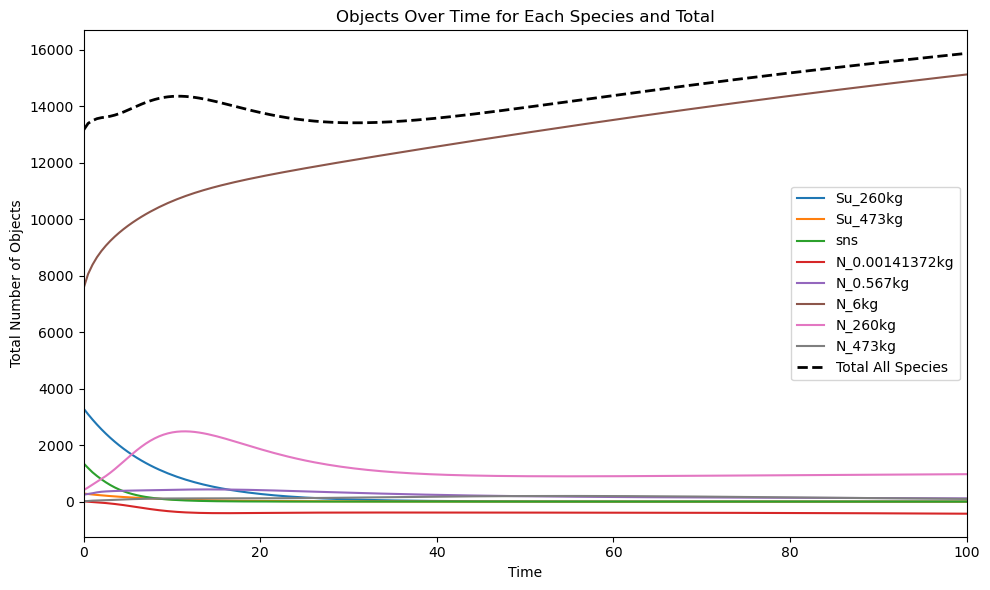

In [85]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming scenario_properties.species_names is available
species_names = scenario_properties.species_names
print(species_names)

plt.figure(figsize=(10, 6))

# Assuming output.y's shape is (n_variables, n_time_points) and is ordered by species
num_species = len(species_names)
num_shells = 40  # Number of shells per species

# Initialize an array to hold the total number of objects at each time point
total_objects_all_species = np.zeros_like(output.t)

# Sum and plot for each species, using species names for labels
for i in range(num_species):
    start_idx = i * num_shells
    end_idx = start_idx + num_shells
    total_objects_per_species = np.sum(output.y[start_idx:end_idx, :], axis=0)  # Sum along the vertical axis
    plt.plot(output.t, total_objects_per_species, label=f'{species_names[i]}')
    
    # Add to the total objects count
    total_objects_all_species += total_objects_per_species

# Plot the total sum line
plt.plot(output.t, total_objects_all_species, label='Total All Species', color='k', linewidth=2, linestyle='--')

plt.xlabel('Time')
plt.ylabel('Total Number of Objects')
plt.title('Objects Over Time for Each Species and Total')
plt.xlim(0, max(output.t))
# Adjust the ylim based on the range of total_objects_all_species if necessary
#plt.ylim(0, np.max(total_objects_all_species) * 1.1)

plt.legend()
plt.tight_layout()
plt.show()

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import imageio
import os

# Update your existing variables as necessary
species_index = 3  # For a specific species of interest
num_shells = 40
time_points = output.t
species_data = output.y
interval_steps = 2  # To plot at each specified interval

# Assuming scenario_properties.R0_km provides the radial distances for each orbital shell
shell_labels = scenario_properties.R0_km

# Setup for saving plots
frames_folder = 'frames'
if not os.path.exists(frames_folder):
    os.makedirs(frames_folder)

filenames = []

# Plotting and saving frames
for i, idx in enumerate(range(0, len(time_points), interval_steps)):
    plt.figure(figsize=(10, 6))
    species_slice = species_data[species_index * num_shells:(species_index + 1) * num_shells, idx]
    plt.bar(range(num_shells), species_slice)
    plt.title(f'Species: {species_names[species_index]}, Year: {round(time_points[idx], 1)}')
    plt.xlabel('Orbital Shell')
    plt.ylabel('Count')
    #plt.ylim(0, np.max(species_data))  # Adjust based on your data

    # Setting custom x-axis labels
    plt.xticks(range(num_shells+1), labels=[f'{label}km' for label in shell_labels], rotation=45, ha='right')
    
    # Save the plot as an image file
    filename = f'{frames_folder}/frame_{i}.png'
    plt.savefig(filename, bbox_inches='tight')  # bbox_inches='tight' helps include labels that may otherwise be cut off
    plt.close()
    filenames.append(filename)

# Creating a GIF
with imageio.get_writer('species_evolution.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Clean up the frames
for filename in filenames:
    os.remove(filename)

D:\TEMP\ipykernel_19712\2873405712.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [60]:
scenario_properties.full_coll[:, 3]

Matrix([
[                                                                 -1.54055759169958e-11*pi*N_0p00141372kg_1**2 - 1.36095621025921e-9*pi*N_0p00141372kg_1*N_0p567kg_1 - 2.3076843152952e-8*pi*N_0p00141372kg_1*N_260kg_1 - 8.39298307814122e-8*pi*N_0p00141372kg_1*N_473kg_1 - 2.57116175562786e-10*pi*N_0p00141372kg_1*N_6kg_1 - 2.20278957369087e-8*pi*N_0p00141372kg_1*Su_260kg_1 - 8.39298307814122e-8*pi*N_0p00141372kg_1*Su_473kg_1 - 2.57116175562786e-10*pi*N_0p00141372kg_1*sns_1 - 6.18317316886717e-9*pi*N_0p567kg_1**2 - 3.99920597020581e-6*pi*N_0p567kg_1*N_260kg_1 - 4.07732948050733e-5*pi*N_0p567kg_1*N_473kg_1 - 1.59875411904111e-8*pi*N_0p567kg_1*N_6kg_1 - 3.95361473720026e-6*pi*N_0p567kg_1*Su_260kg_1 - 4.11494322110242e-5*pi*N_0p567kg_1*Su_473kg_1 - 1.65313351084523e-8*pi*N_0p567kg_1*sns_1 - 1.93527556869263e-5*pi*N_260kg_1**2 - 9.18045996274867e-5*pi*N_260kg_1*N_473kg_1 - 3.81634792567437e-6*pi*N_260kg_1*N_6kg_1 - 1.90465411982091e-5*pi*N_260kg_1*Su_260kg_1 - 9.07282907481023e-5*pi*N_

In [ ]:
scn

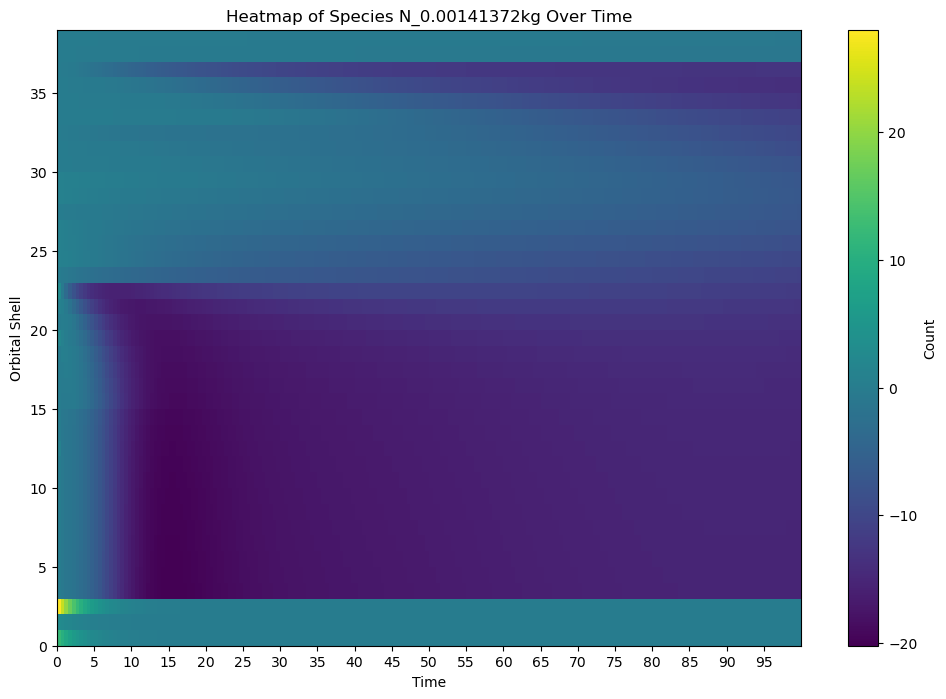

In [86]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming we're focusing on a specific species for simplicity
species_index = 3  # Example index for a species
num_shells = 39  # Total number of orbital shells
species_data = output.y[species_index * num_shells:(species_index + 1) * num_shells, :]  # Example data slice

# Create a heatmap
plt.figure(figsize=(12, 8))
plt.imshow(species_data, aspect='auto', origin='lower', cmap='viridis',
           extent=[output.t[0], output.t[-1], 0, num_shells])

# Labeling
plt.colorbar(label='Count')
plt.xlabel('Time')
plt.ylabel('Orbital Shell')
plt.title(f'Heatmap of Species {species_names[species_index]} Over Time')

plt.xticks(np.arange(output.t[0], output.t[-1], step=5))  # Example time step
plt.yticks(np.arange(0, num_shells, step=5))  # Example shell step

plt.show()

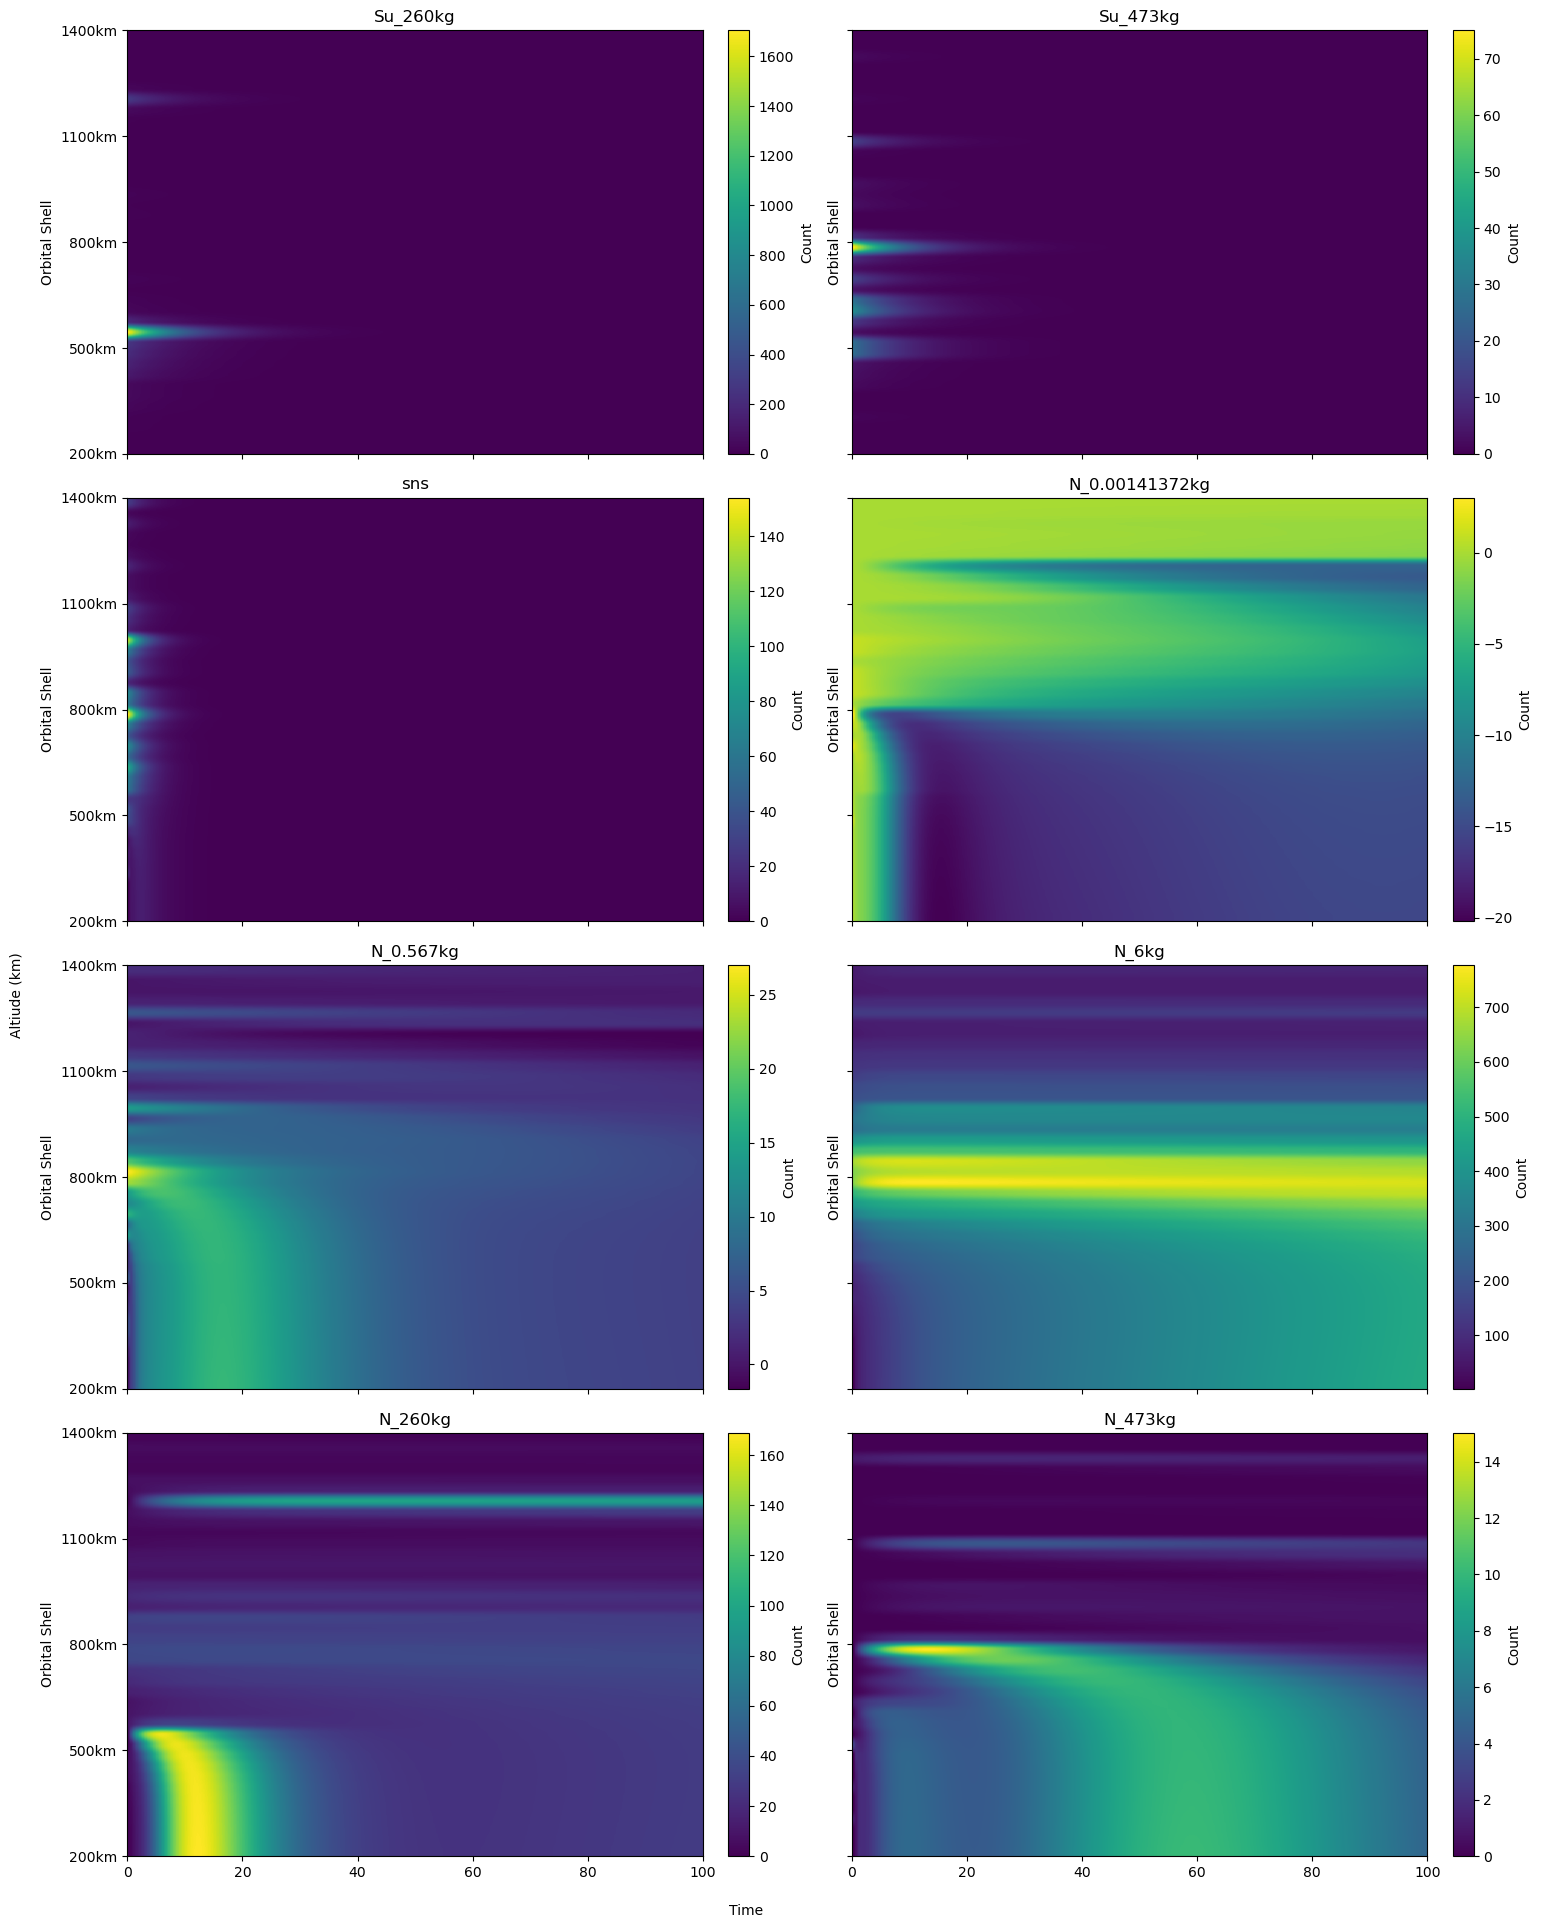

In [87]:
num_species = 8  # Total number of species
num_shells = 40  # Total number of orbital shells per species
time_steps = len(output.t)  # Number of time steps

# Create a figure with subplots arranged in a 4x2 grid
fig, axes = plt.subplots(4, 2, figsize=(16, 20), sharex=True, sharey=True)

for i in range(num_species):
    # Calculate row and column index for the current species
    row = i // 2
    col = i % 2

    # Extract data for each species
    species_data = output.y[i * num_shells:(i + 1) * num_shells, :]
    ax = axes[row, col]
    heatmap = ax.imshow(species_data, aspect='auto', origin='lower', cmap='viridis',
                        extent=[output.t[0], output.t[-1], 0, num_shells])
    
    # Add a colorbar for each subplot, adjust if necessary
    cbar = fig.colorbar(heatmap, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Count')
    
    # Customizing the plot
    ax.set_ylabel('Orbital Shell')
    ax.set_yticks(np.linspace(0, num_shells, num=5))
    ax.set_yticklabels([f'{alt:.0f}km' for alt in np.linspace(scenario_properties.R0_km[0], scenario_properties.R0_km[-1], num=5)])

    # Title for each species
    ax.set_title(f'{species_names[i]}')

# Shared x-axis label
fig.text(0.5, 0.04, 'Time', ha='center')
# Shared y-axis label
fig.text(0.04, 0.5, 'Altiude (km)', va='center', rotation='vertical')

plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Adjust the layout to make room for the shared axis labels
plt.show()

D:\TEMP\ipykernel_19712\2148779833.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0.05, 0.9, 1])  # Adjust the layout to make room for the colorbar


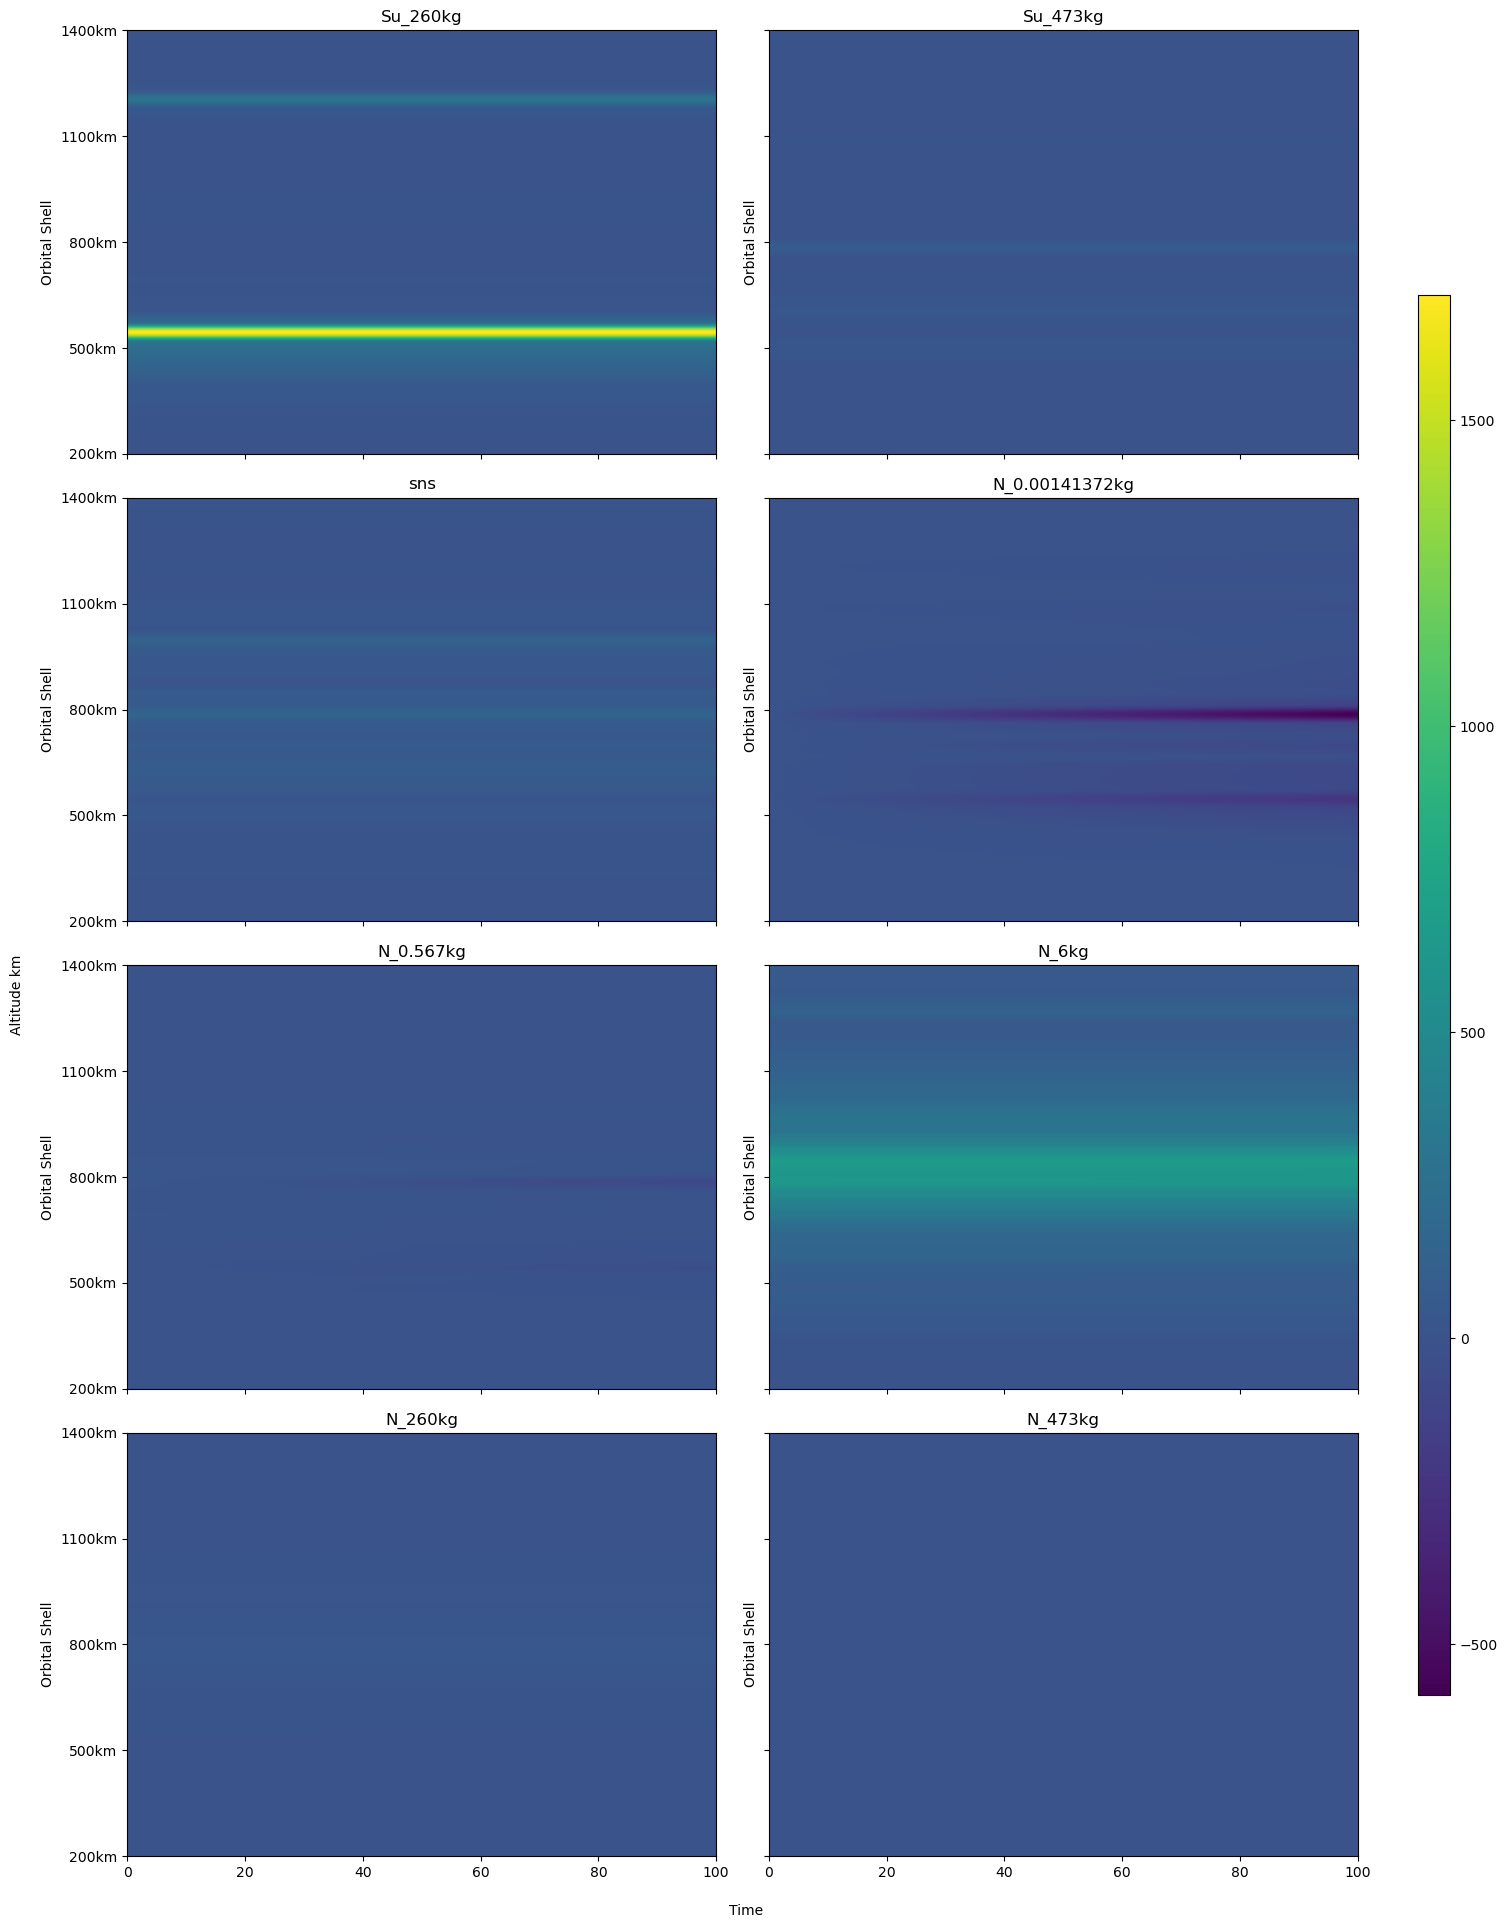

In [78]:
# Assuming output.t and output.y are defined as before
num_species = 8
num_shells = 40
time_steps = len(output.t)

# Find global min and max for the color scale across all species
global_min = np.min(output.y)
global_max = np.max(output.y)

# Create a figure with subplots arranged in a 4x2 grid
fig, axes = plt.subplots(4, 2, figsize=(16, 20), sharex=True, sharey=True)

for i in range(num_species):
    # Calculate row and column index for the current species
    row = i // 2
    col = i % 2

    # Extract data for each species
    species_data = output.y[i * num_shells:(i + 1) * num_shells, :]
    ax = axes[row, col]
    heatmap = ax.imshow(species_data, aspect='auto', origin='lower', cmap='viridis',
                        extent=[output.t[0], output.t[-1], 0, num_shells],
                        vmin=global_min, vmax=global_max)  # Apply global color scale
    
    # Customizing the plot
    ax.set_ylabel('Orbital Shell')
    ax.set_yticks(np.linspace(0, num_shells, num=5))
    ax.set_yticklabels([f'{alt:.0f}km' for alt in np.linspace(scenario_properties.R0_km[0], scenario_properties.R0_km[-1], num=5)])

    # Title for each species
    ax.set_title(f'{species_names[i]}')

# Add a single colorbar for the entire figure
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust the position as needed
fig.colorbar(heatmap, cax=cbar_ax, orientation='vertical')
cbar_ax.set_label('Count')

# Shared x-axis label
fig.text(0.5, 0.04, 'Time', ha='center')
# Shared y-axis label
fig.text(0.04, 0.5, 'Altitude km', va='center', rotation='vertical')

plt.tight_layout(rect=[0.05, 0.05, 0.9, 1])  # Adjust the layout to make room for the colorbar
plt.show()